In [1]:
import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

from wimpy.xenon.base_model import config as base_config
from wimpy.likelihood import LogLikelihood

In [2]:
from copy import deepcopy
config = deepcopy(base_config)
config['pdf_sampling_multiplier'] = 0.1
config['sources'] = config['sources'][:1]  #   Set only the ER background

# Get "real" data

In [3]:
# A reference model and a toy dataset to stand in for real data
from wimpy.model import Model
ref_m = Model(config)

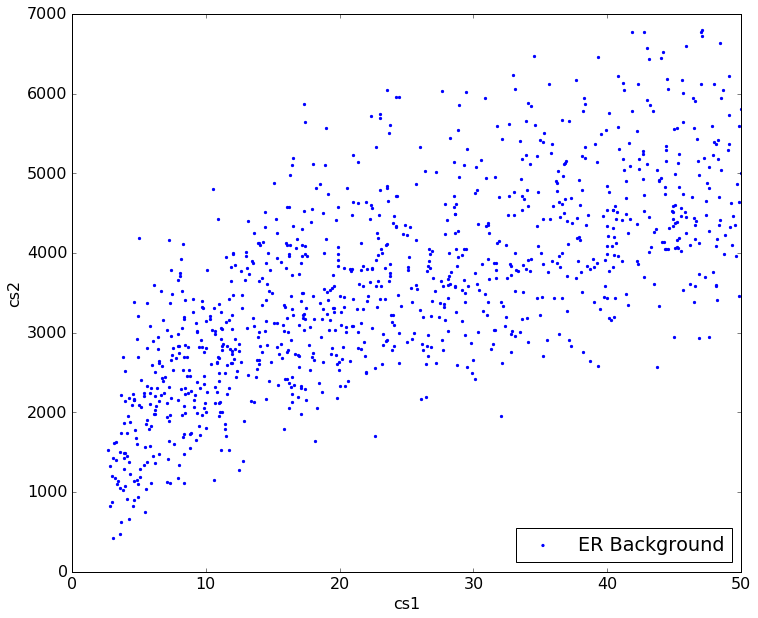

In [4]:
dataset = ref_m.simulate()
ref_m.show(dataset)
plt.legend(loc='lower right', scatterpoints=1)

In [5]:
example_dsets = [ref_m.simulate() for _ in range(100)]

# One rate uncertainty

In [6]:
lf_simple = LogLikelihood(config)
lf_simple.add_rate_parameter('er_bg')
lf_simple.set_data(dataset)

In [7]:
lf_simple(er_bg_rate=3)

-6248.5984710776029

(2, 4)

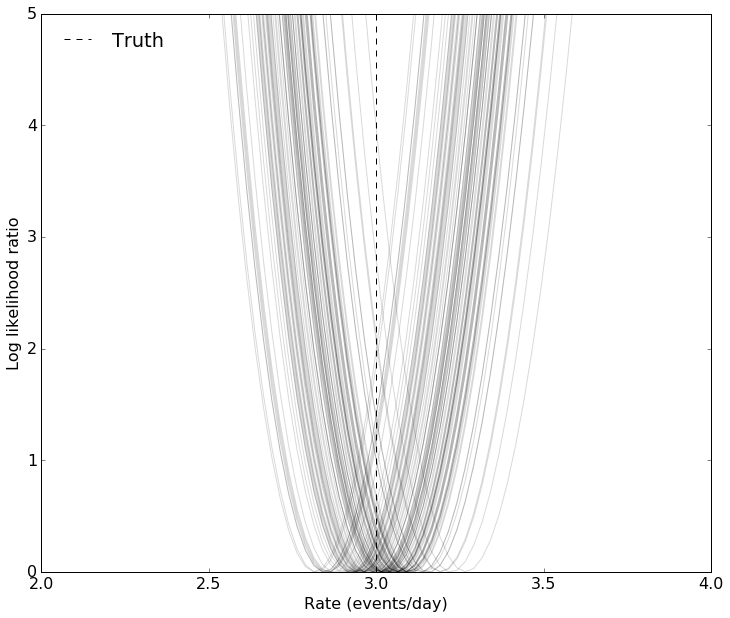

In [9]:
x = np.linspace(0, 5, 200)

for d in example_dsets:
    lf_simple.set_data(d)
    loglikelihoods = np.array([lf_simple(er_bg_rate=q) for q in x])
    plt.plot(x, loglikelihoods.max()-loglikelihoods, alpha=0.15, c='k')
plt.ylim(0, 5)
plt.ylabel("Log likelihood ratio")
plt.xlabel("Rate (events/day)")
plt.axvline(ref_m.get_source('er_bg').events_per_day, c='k', linestyle='--',
            label='Truth')
plt.legend(frameon=False, loc='upper left')
plt.xlim(2, 4)

# One shape uncertainty

In [135]:
lf = LogLikelihood(config)
lf.add_shape_parameter('recombination_fluctuation', anchors=(1e-9, 0.05, 0.1, 0.15))
lf.prepare()

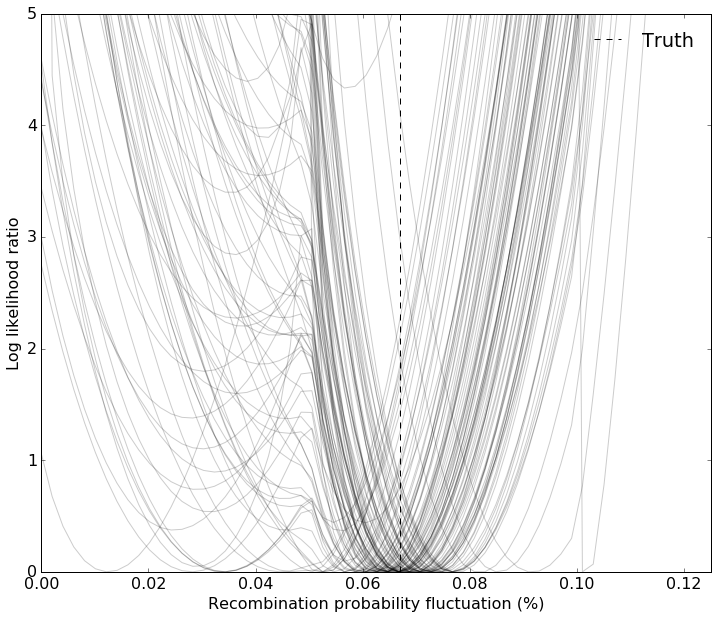

In [185]:
for d in tqdm(example_dsets):
    lf.set_data(d)
    x = np.linspace(1e-9, 0.2, 100)
    ls = np.array([lf(recombination_fluctuation=q) for q in x])
    plt.plot(x, ls.max()-ls, c='k', alpha=0.2)
plt.ylim(0, 5)
plt.xlim(x.min(), 0.125)
plt.ylabel("Log likelihood ratio")
plt.xlabel("Recombination probability fluctuation (%)")
plt.axvline(ref_m.config.get('recombination_fluctuation'), c='k', linestyle='--',
            label='Truth')
plt.legend(frameon=False, loc='upper right')

As you can see, the log-likelihood curves we get are now very non-parabolic. This means we've been too cheap, and need to simulate more events (or use less bins in the PDF generation).

In [168]:
config_more = deepcopy(config)
config_more['pdf_sampling_multiplier'] = 1

lf_more = LogLikelihood(config_more)
lf_more.add_shape_parameter('recombination_fluctuation', anchors=(1e-9, 0.05, 0.1, 0.2))
lf_more.prepare()

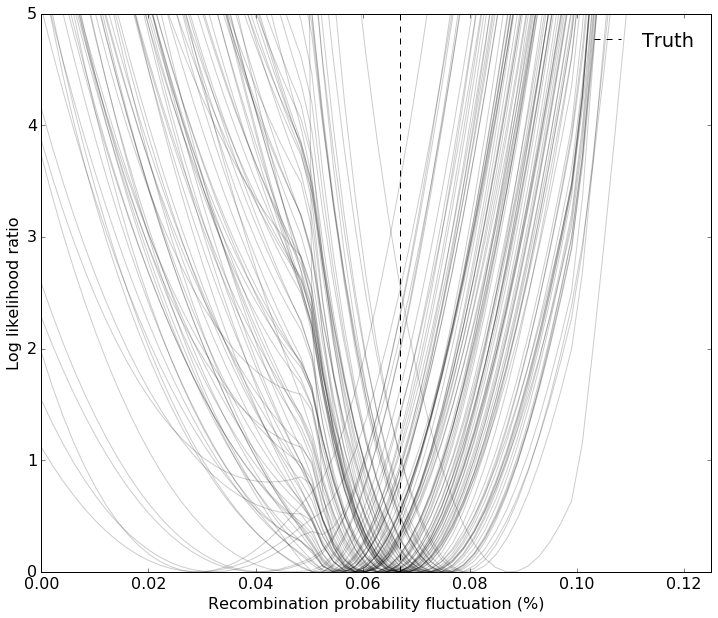

In [186]:
for d in tqdm(example_dsets):
    lf_more.set_data(d)
    x = np.linspace(1e-9, 0.2, 100)
    ls = np.array([lf_more(recombination_fluctuation=q) for q in x])
    plt.plot(x, ls.max()-ls, c='k', alpha=0.2)
plt.ylim(0, 5)
plt.xlim(0, 0.125)
plt.ylabel("Log likelihood ratio")
plt.xlabel("Recombination probability fluctuation (%)")
plt.axvline(ref_m.config.get('recombination_fluctuation'), c='k', linestyle='--',
            label='Truth')
plt.legend(frameon=False, loc='upper right')

In [184]:
lf_moreanchors = LogLikelihood(config_more)
lf_moreanchors.add_shape_parameter('recombination_fluctuation', anchors=(1e-9, 0.025, 0.05, 0.075, 0.1, 0.125,))
lf_moreanchors.prepare()

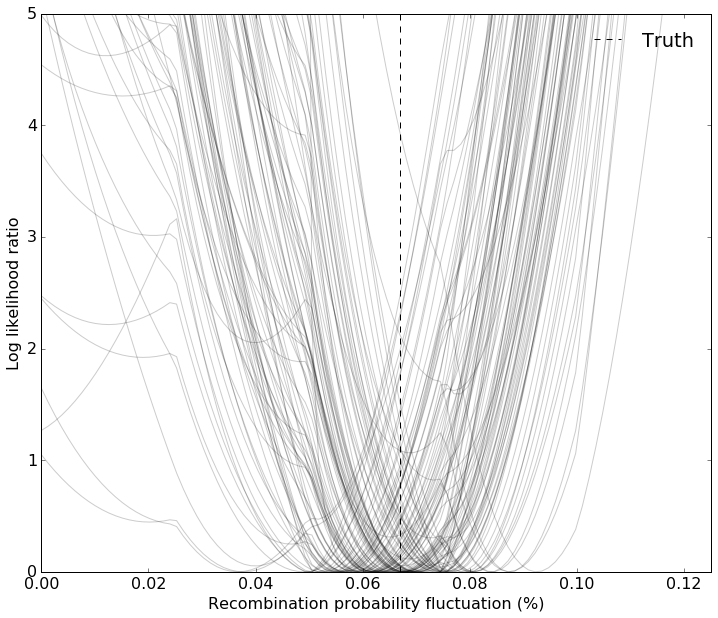

In [187]:
for d in tqdm(example_dsets):
    lf_moreanchors.set_data(d)
    x = np.linspace(1e-9, 0.125, 100)
    ls = np.array([lf_moreanchors(recombination_fluctuation=q) for q in x])
    plt.plot(x, ls.max()-ls, c='k', alpha=0.2)
plt.ylim(0, 5)
plt.xlim(x.min(), x.max())
plt.ylabel("Log likelihood ratio")
plt.xlabel("Recombination probability fluctuation (%)")
plt.axvline(ref_m.config.get('recombination_fluctuation'), c='k', linestyle='--',
            label='Truth')
plt.legend(frameon=False, loc='upper right')

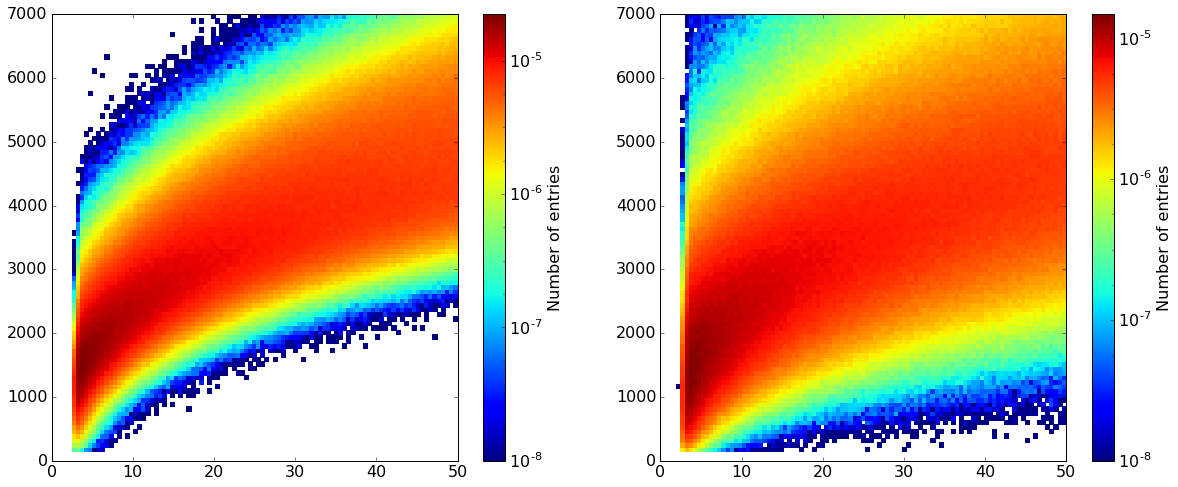

In [129]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plt.sca(ax1)
lf.anchor_models[min(list(lf.anchor_models.keys()))].sources[0].pdf_histogram.plot(log_scale=True, vmin=1e-8)
plt.sca(ax2)
lf.anchor_models[max(list(lf.anchor_models.keys()))].sources[0].pdf_histogram.plot(log_scale=True, vmin=1e-8)

# Rate and shape uncertainty, 1d measurement space

In [188]:
c = deepcopy(config)
c['analysis_space'] = tuple([('cs1', tuple(np.linspace(0, 50, 50)))])

In [189]:
lf1d = LogLikelihood(c)
lf1d.add_rate_parameter('er_bg')
lf1d.add_shape_parameter('ph_detection_efficiency', anchors=(0.08, 0.1, 0.15, 0.2))
lf1d.prepare()
lf1d.set_data(dataset)

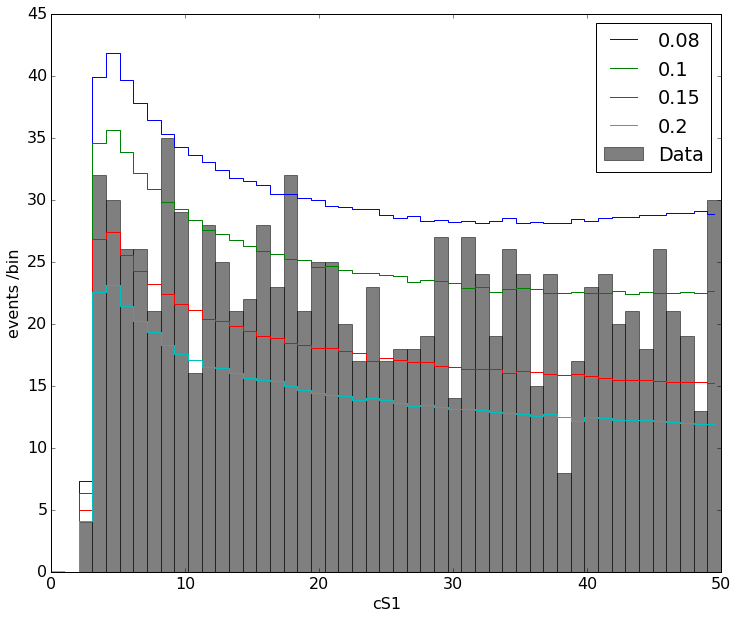

In [190]:
for z, m in sorted(lf1d.anchor_models.items()): 
    mu = m.expected_events()[0]
    pdf = m.sources[0].pdf_histogram
    pdf = pdf/pdf.n  # Normalize to 1, s
    (m.sources[0].pdf_histogram * mu).plot(label=z[0])
plt.hist(dataset['cs1'], bins=np.linspace(0, 50, 50), color='k', label='Data', alpha=0.5)
plt.legend()
plt.xlabel("cS1")
plt.ylabel("events /bin")

In [191]:
def twod_l_plot(lf, dims, x, y, sigmamax=10):
    results = []
    for z1 in x:
        results.append([])
        for z2 in y:
            results[-1].append(lf(**{dims[0]:z1, dims[1]:z2}))

    z1, z2 = np.meshgrid(x, y)
    results = np.array(results)
    
    plt.pcolormesh(z1, z2, np.sqrt(2*(results.max() - results.T)), vmax=sigmamax) 
    plt.colorbar(label="$\sigma = \sqrt{2 t}$")
    plt.xlabel(dims[0])
    plt.ylabel(dims[1])

(0.08, 0.2)

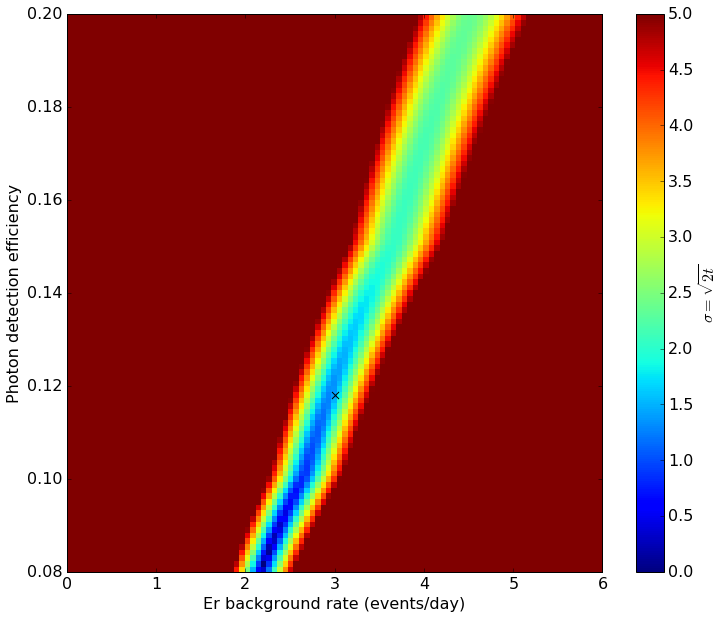

In [192]:
mean = lf1d.base_model.get_source('er_bg').events_per_day
twod_l_plot(lf1d, ['er_bg_rate', 'ph_detection_efficiency'], 
            x=np.linspace(0, 2 * mean, 100),
            y=np.linspace(0.08, 0.2, 100),
            sigmamax=5)
plt.scatter([mean], [lf1d.base_model.config.get('ph_detection_efficiency')], 
            c='k', marker='x', s=50)
plt.xlim(0, 2 * mean)
plt.xlabel("Er background rate (events/day)")
plt.ylabel("Photon detection efficiency")
plt.ylim(0.08, 0.2)

# 2d, two shape uncertainties

In [ ]:
# LATER =]

In [194]:
config['pdf_sampling_multiplier'] = 0.1
lftwo = LogLikelihood(config)
lftwo.add_shape_parameter('ph_detection_efficiency', spread=0.1, anchors=(-3, -2, 1, 0, 1, 2, 3))
lftwo.add_shape_parameter('s2_gain', spread=0.1, anchors=(-3, -2, 1, 0, 1, 2, 3))
lftwo.prepare()
lftwo.set_data(dataset)

TypeError: add_shape_parameter() got an unexpected keyword argument 'spread'

In [91]:
lf.shape_uncertainties

OrderedDict([('ph_detection_efficiency',
              {-3: 0.08259999999999999,
               -2: 0.0944,
               0: 0.118,
               1: 0.1298,
               2: 0.14159999999999998,
               3: 0.1534}),
             ('s2_gain',
              {-3: 18.2,
               -2: 20.8,
               0: 26.0,
               1: 28.6,
               2: 31.2,
               3: 33.800000000000004})])

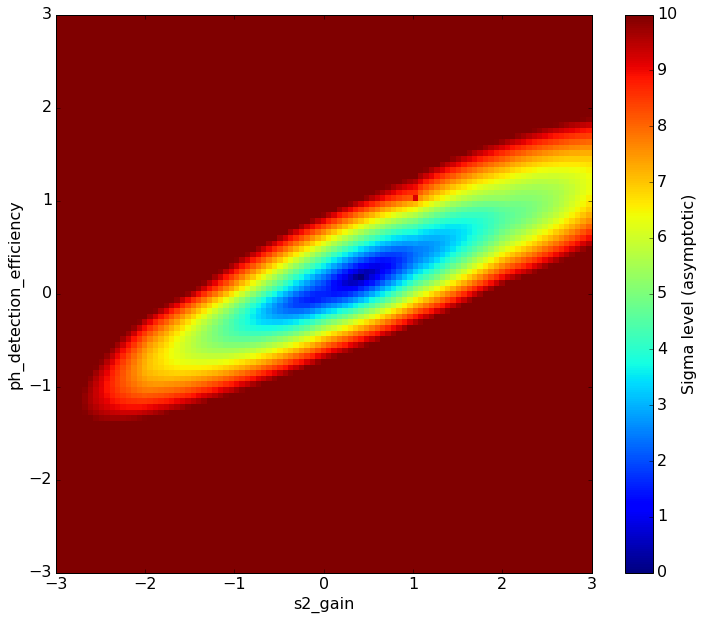

In [140]:
twod_l_plot(lf, ['s2_gain', 'ph_detection_efficiency'], zmax=3)

You can clearly see the correlation of the two parameters, which is expected since the ER spectrum is uniform. The choppiness at higher LR values is due to the likelihood changing quickly between the anchor points. 